[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imeri-course/ai-in-healthcare/blob/master/Session4/Demo_LSTM.ipynb)

In [ ]:
# install all dependecies
!pip install -qq arff2pandas

In [2]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Table of Content
1.  About ECG5000 Dataset
1.  Exploratory Data Analysis (EDA)
    1.  Data Info
        1. Check Class Distribution
        1. Check Averaged data
1.  Data Preparation
    1.  Split between data normal and abnormal
    1.  Split to Train, Valid, Test data
    1.  Create Data Abstraction
    1.  Compose all to DataLoader
1.  Training Preparation
    1.  Create Model Architecture
    1.  Set Training Model
    1.  Set Optimizer
    1.  Set Criterion
1.  Training
1.  Results
    1.  Plot Loss Result
    1.  Choose a Threshold
    1.  Check The Examples

# 1. About ECG5000 Dataset

The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)


Reference Code: [autoencoder-for-anomaly-detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)

# 2. Exploratory Data Analysis (EDA)

In [3]:
# # Download data
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
!unzip -qq ECG5000.zip

In [4]:
# Load data
with open('ECG5000_TRAIN.arff') as f:
    train = a2p.load(f)

with open('ECG5000_TEST.arff') as f:
    test = a2p.load(f)

Combine train and test data to single  data frame

In [5]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [6]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,1
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,1
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,1
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,1
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,1


Convert last name with name `target`

In [7]:
df.rename(columns={df.columns[-1]: 'target'}, inplace=True)
df['target'] = df['target'].astype('int')

In [8]:
# Initial Class Name
CLASS_NORMAL = 1
class_names = ['Normal','R on T','PVC','SP','UB']

## 2.1. Data Info

### 2.1.1 Check Class Distribution

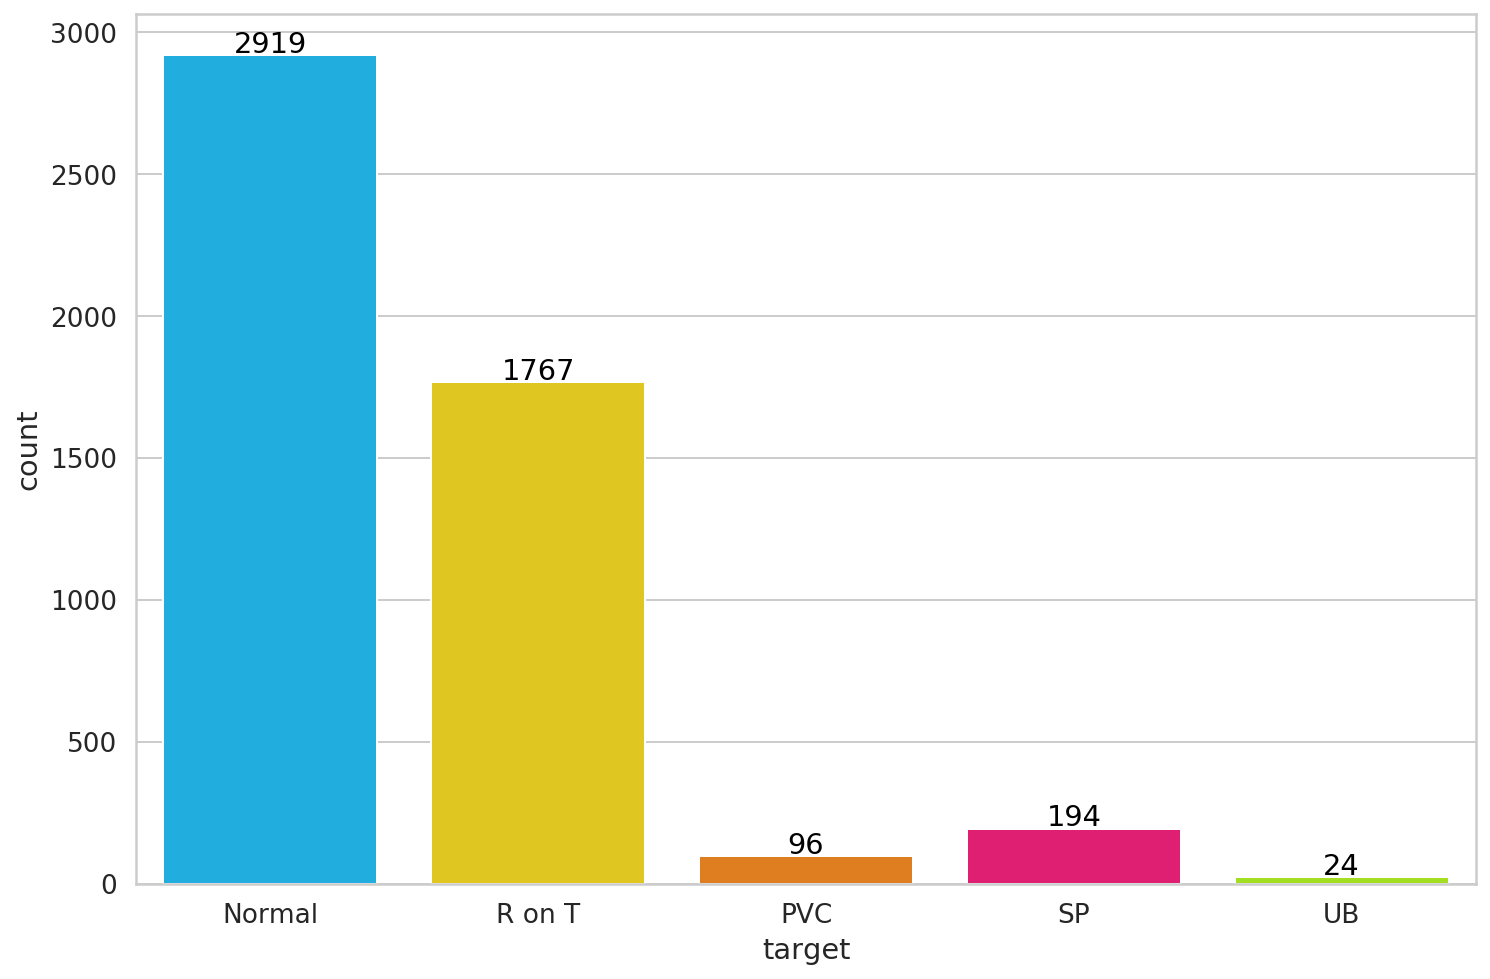

In [9]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names);
for index, values in df.groupby('target').size().items():
    ax.text(int(index)-1, values+10, values,  color='black', ha="center")

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

### 2.1.2 Check averaged data
Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [160]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    smooth_path = time_series_df.rolling(n_steps).mean()
    path_deviation = 2 * time_series_df.rolling(n_steps).std()

    under_line = (smooth_path - path_deviation)[0]
    over_line = (smooth_path + path_deviation)[0]

    ax.plot(smooth_path, linewidth=2)
    ax.fill_between(
        path_deviation.index,
        under_line,
        over_line,
        alpha=.125
    )
    ax.set_title(class_name)

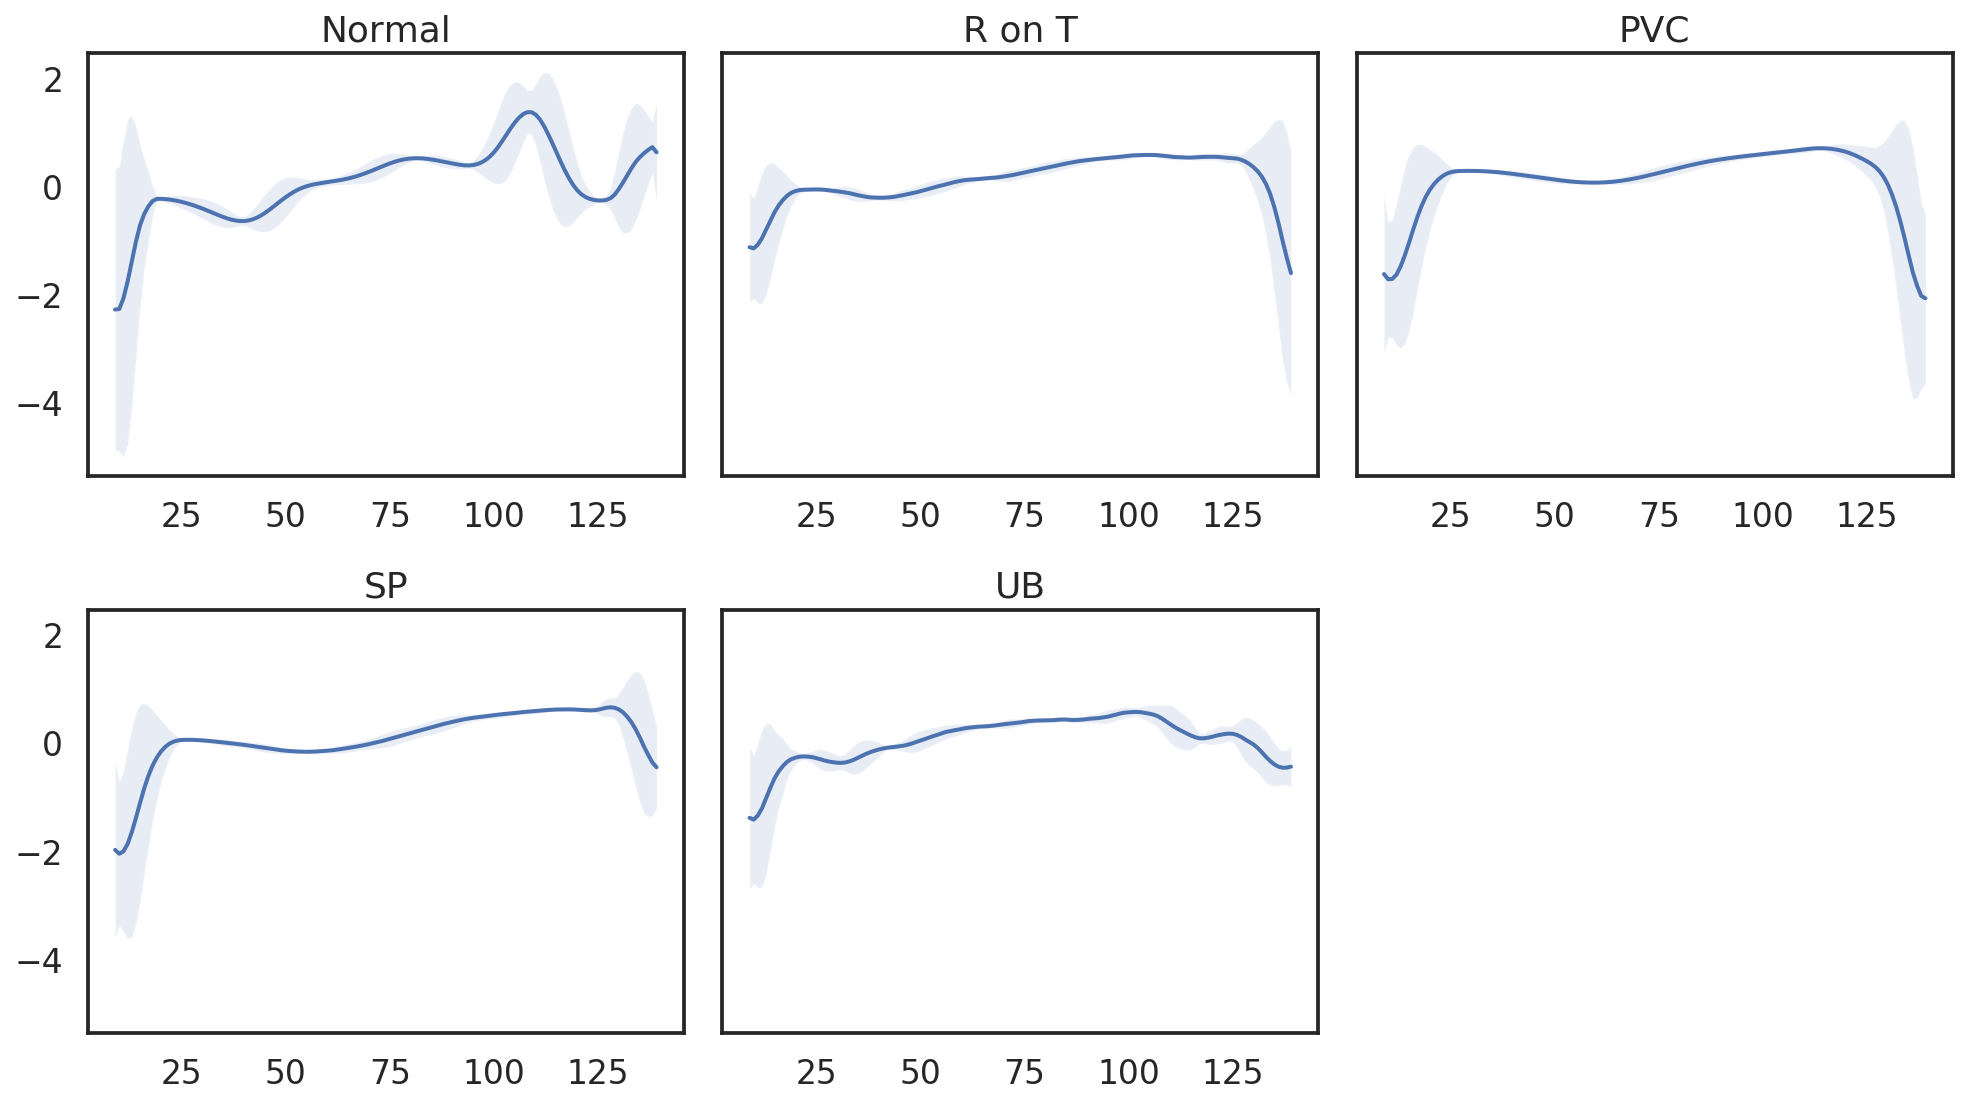

In [161]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.target == cls] \
        .drop(labels='target', axis=1) \
        .mean(axis=0) \
        .to_numpy()
    plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

# 3. Data Preparation

![data preprocessing](../Session3/pytorch_data_pipeline.png)

## 3.1 Split between data normal and abnormal

In [12]:
# put data normal to normal_df
df_normal = df[df['target'] == CLASS_NORMAL]
df_normal.shape

(2919, 141)

In [13]:
df_anomaly = df[df['target'] != CLASS_NORMAL]
df_anomaly.shape

(2081, 141)

column number 141 is `target`

## 3.2. Split to Train, Valid, Test data
To get data train, valid and testing we can splitting using sklearn train_test_split twice

In [14]:
from sklearn.model_selection import train_test_split

# Split Dataset to train and validation
df_train, df_valid = train_test_split(df_normal, test_size=0.15, random_state=RANDOM_SEED)

# Split data validation with data test
df_valid, df_test = train_test_split(df_valid, test_size=0.33, random_state=RANDOM_SEED)

# check data
total_data = df_normal.shape[0]
print("Train/Valid/Test : {:0.2f}%/{:0.2f}%/{:0.2f}%".format(df_train.shape[0]/total_data, df_valid.shape[0]/total_data, df_test.shape[0]/total_data))

Train/Valid/Test : 0.85%/0.10%/0.05%


## 3.4. Create Data Abstraction

In [15]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ECG5000(Dataset):
    CLASS = {'Normal': 1, 'R on T': 2,'PVC' :3 ,'SP': 4,'UB': 5}
    
    def __init__(self, df, transform=None):
        self.target = df['target'].astype('int').values
        self.df = df.drop(labels='target', axis=1)
        sequences = self.df.astype(np.float32).to_numpy().tolist()
        self.dataset = torch.stack([torch.tensor(s).unsqueeze(1).float() for s in sequences])
        self.transform = transform
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def class_to_numeric(self, name):
        return self.CLASS[name]
    
    def numeric_to_class(self, num):
        return {y:x for x,y in self.CLASS.iteritems()}[num]
    
    @property
    def seq_len(self):
        return self.dataset.shape[1]
    
    @property
    def n_features(self):
        return self.dataset.shape[2]
    
    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.target[idx]
        
        # if any transform
        if self.transform:
            data = self.transform(data)
            
        return data, label

## 3.6. Compose all to DataLoader
Sometimes one epoch is too big to feed to the computer at once we divide it in several smaller batches. <br>
`Epoch` = **One Epoch** is when an **ENTIRE dataset** is passed **forward** and **backward** through the neural network **only ONCE**. <br>
`Batch Size` = Total number of training examples present **in a single batch**.

In [21]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
transform = None

# Parameter batch_size
train_batchsize = 256
valid_batchsize = 256
test_batchsize = 256

# Construct pipeline
train_dataset = ECG5000(df_train, transform)
valid_dataset = ECG5000(df_valid, transform)
test_dataset = ECG5000(df_test, transform)
test_anomaly_dataset = ECG5000(df_anomaly, transform)

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=train_batchsize)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batchsize)
test_dataloader = DataLoader(test_dataset, batch_size=test_batchsize)
test_anomaly_dataloader = DataLoader(test_anomaly_dataset, batch_size=test_batchsize)

In [22]:
# get sample data
examples = enumerate(train_dataloader)
batch_idx, (example_data, example_targets) = next(examples)

In [23]:
batch_idx

0

In [24]:
example_data.shape

torch.Size([256, 140, 1])

In [25]:
example_targets.shape

torch.Size([256])

# 4. Training Preparation

## 4.1 Create Model Architecture 
![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [105]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.view(-1, self.seq_len, self.n_features)

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.view(-1, self.n_features, self.embedding_dim)

In [28]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )

        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(1, self.seq_len, self.n_features)
        x = x.view(-1, self.seq_len, self.input_dim)

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.view(-1, self.seq_len, self.hidden_dim)

        return self.output_layer(x)

In [29]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        # Set Encoder
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        # Set Decoder
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## 4.2. Set Training Model

In [41]:
seq_len = train_dataset.seq_len
n_features = train_dataset.n_features
network = RecurrentAutoencoder(seq_len, n_features, 128)

# with Cuda Gpu Acceleration
if torch.cuda.is_available():
    network.cuda()

## 4.3. Set Optimizer
- [Simple theory of Optimizers](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3)
- [Torch optim doc](https://pytorch.org/docs/stable/optim.html)

In [42]:
learning_rate = 1e-3
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

## 4.4. Set Criterion
- [a brief overview of loss function in pytorch](https://medium.com/udacity-pytorch-challengers/a-brief-overview-of-loss-functions-in-pytorch-c0ddb78068f7)

In [43]:
criterion = nn.L1Loss(reduction='mean')

# 5. Training

In [44]:
from tqdm import tqdm

def one_epoch_train(idx_epoch, network, optimizer, data_loader, verbose=False):
    """
    One Epoch Training Function
    """
    # init arrays
    loss_epoch = np.zeros(len(data_loader))
    
    # Set to Train mode on
    network.train() 
    # Start Training
    pbar = tqdm(data_loader, desc=f"train epoch {idx_epoch}", disable=not verbose)
    for batch_idx, (data, target) in enumerate(pbar):
        
        # Convert data and target to cuda datatype
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        # Main Training Process
        optimizer.zero_grad() # Clear all Gradient in Optimizer
        output = network(data) # Forward Propagation
        loss = criterion(output, data) # Calculcate loss between forward result and target
        loss.backward() # Backward Propagation
        optimizer.step() # Update Gradient in Optimizer
        
        # Put loss and accuracy to arrays
        loss_epoch[batch_idx] = loss.item()
        
        # Add loss and acc in progress bar
        pbar.set_postfix(loss='{:0.4f}'.format(loss.item()))
        
    return loss_epoch

def one_epoch_test(idx_epoch, network, optimizer, data_loader, verbose=False):
    """
    One Epoch Testing Function
    """
    # init arrays
    loss_epoch = np.zeros(len(data_loader))
    
    # Set to Train mode of
    network.eval()
    
    pbar = tqdm(data_loader, desc=f"eval epoch {idx_epoch}", disable=not verbose)
    
    # Should deactivate all gradient proccess
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(pbar):

            # Convert data and target to cuda datatype
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            # Main Training Process
            output = network(data) # Only Forward Propagation
            loss = criterion(output, data) # Calculcate loss between forward result and target

            # Put loss and accuracy to arrays
            loss_epoch[batch_idx] = loss.item()
            
            # Add loss and acc in progress bar
            pbar.set_postfix(loss='{:0.4f}'.format(loss.item()))
        
    return loss_epoch

In [68]:
n_epochs = 200
log_interval = 1

train_losses = []
test_losses = []

for idx_epoch in range(1, n_epochs+1):
    train_loss = one_epoch_train(idx_epoch ,network, optimizer, train_dataloader)
    test_loss = one_epoch_test(idx_epoch, network, optimizer, valid_dataloader)
    test_loss = test_loss.mean()
    
    train_losses += list(train_loss)
    test_losses += [None]*(len(train_loss)-1) + [test_loss]
    
    if idx_epoch % log_interval == 0:
        print('Train Epoch: {}/{} \t loss(train | valid): {:.6f} | {:.6f}'.format(idx_epoch, n_epochs, train_loss.mean(), test_loss))

Train Epoch: 1/50 	 loss(train | valid): 0.310428 | 0.278656
Train Epoch: 2/50 	 loss(train | valid): 0.317197 | 0.325153
Train Epoch: 3/50 	 loss(train | valid): 0.273132 | 0.235422
Train Epoch: 4/50 	 loss(train | valid): 0.294982 | 0.275823
Train Epoch: 5/50 	 loss(train | valid): 0.260603 | 0.294146
Train Epoch: 6/50 	 loss(train | valid): 0.249049 | 0.221591
Train Epoch: 7/50 	 loss(train | valid): 0.237596 | 0.232730
Train Epoch: 8/50 	 loss(train | valid): 0.256486 | 0.286293
Train Epoch: 9/50 	 loss(train | valid): 0.242171 | 0.223645
Train Epoch: 10/50 	 loss(train | valid): 0.250638 | 0.267739
Train Epoch: 11/50 	 loss(train | valid): 0.244821 | 0.350053
Train Epoch: 12/50 	 loss(train | valid): 0.237521 | 0.216540
Train Epoch: 13/50 	 loss(train | valid): 0.250300 | 0.263625
Train Epoch: 14/50 	 loss(train | valid): 0.256039 | 0.219105
Train Epoch: 15/50 	 loss(train | valid): 0.233960 | 0.274203
Train Epoch: 16/50 	 loss(train | valid): 0.231962 | 0.247349
Train Epoch: 17/5

# 6. Results

In [46]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

def plot_(train, test=None, xlabel="epoch", ylabel="loss", title="Result Training", rolling=20):
    """
    Function for plot the result
    """
    df = pd.DataFrame()
    df['train'] = train
    df = df.rolling(rolling).mean()
    sns.lineplot(hue="region", style="event",data=df[['train']])
    if test:
        df['test'] = test
        sns.scatterplot(data=df[['test']], palette="flag_r")

    # other info
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## 6.1. Plot Loss Result

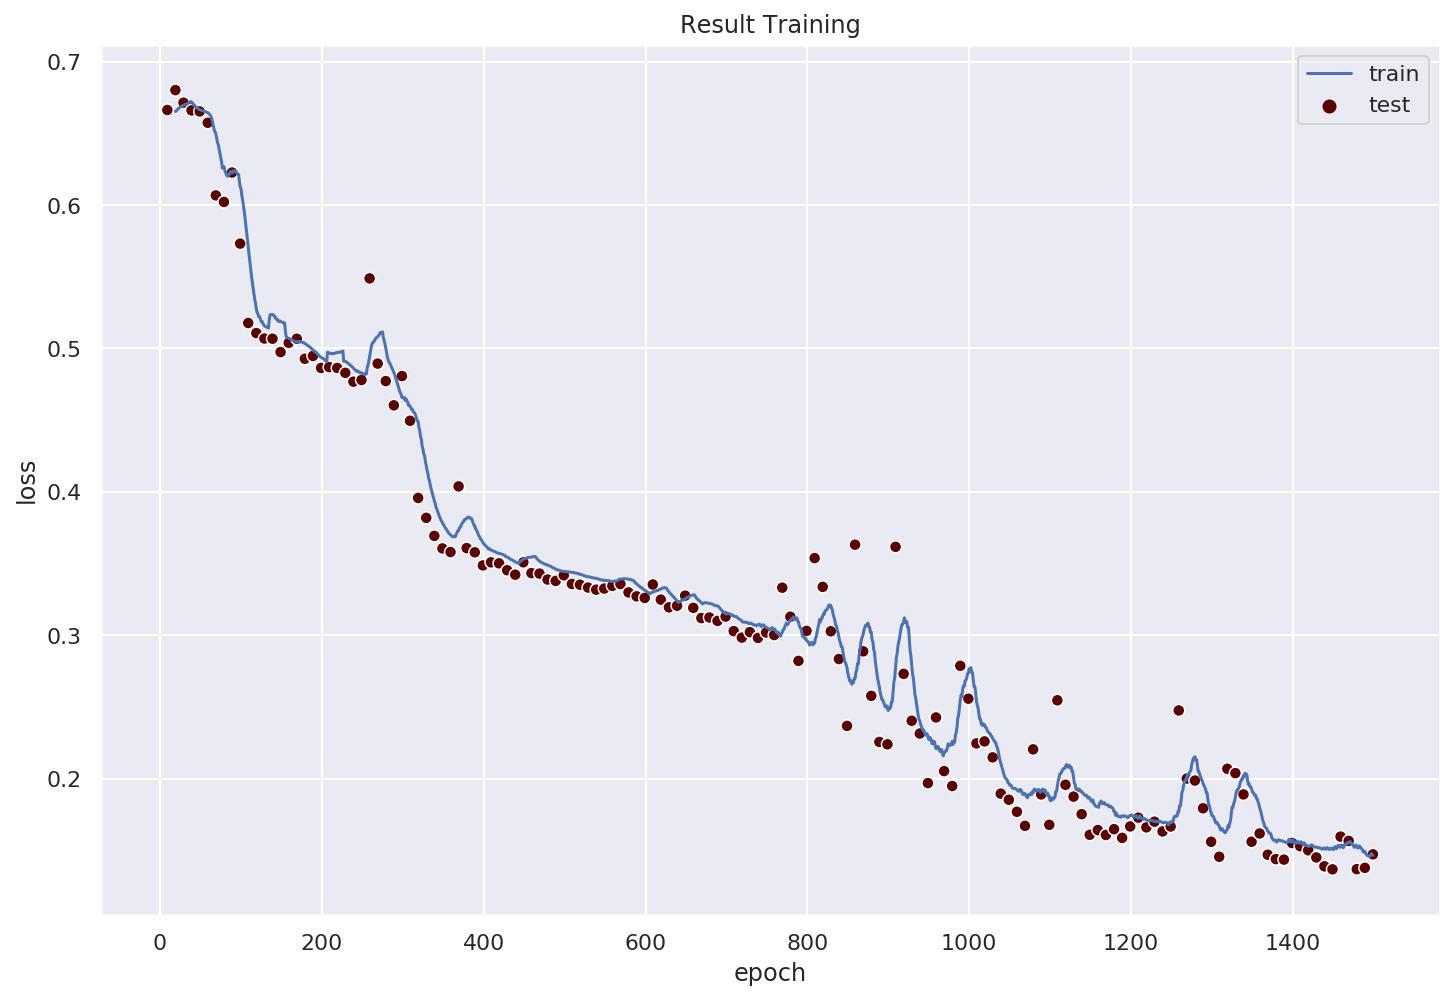

In [47]:
# Check Loss
plot_(train_losses, test_losses)

## 6.2. Choose a Threshold

To predict the anomaly data, we can use the loss function value. we can use a loss threshold to distinct between normal data and anomaly data

### 6.2.1. Check loss distribution for normal data

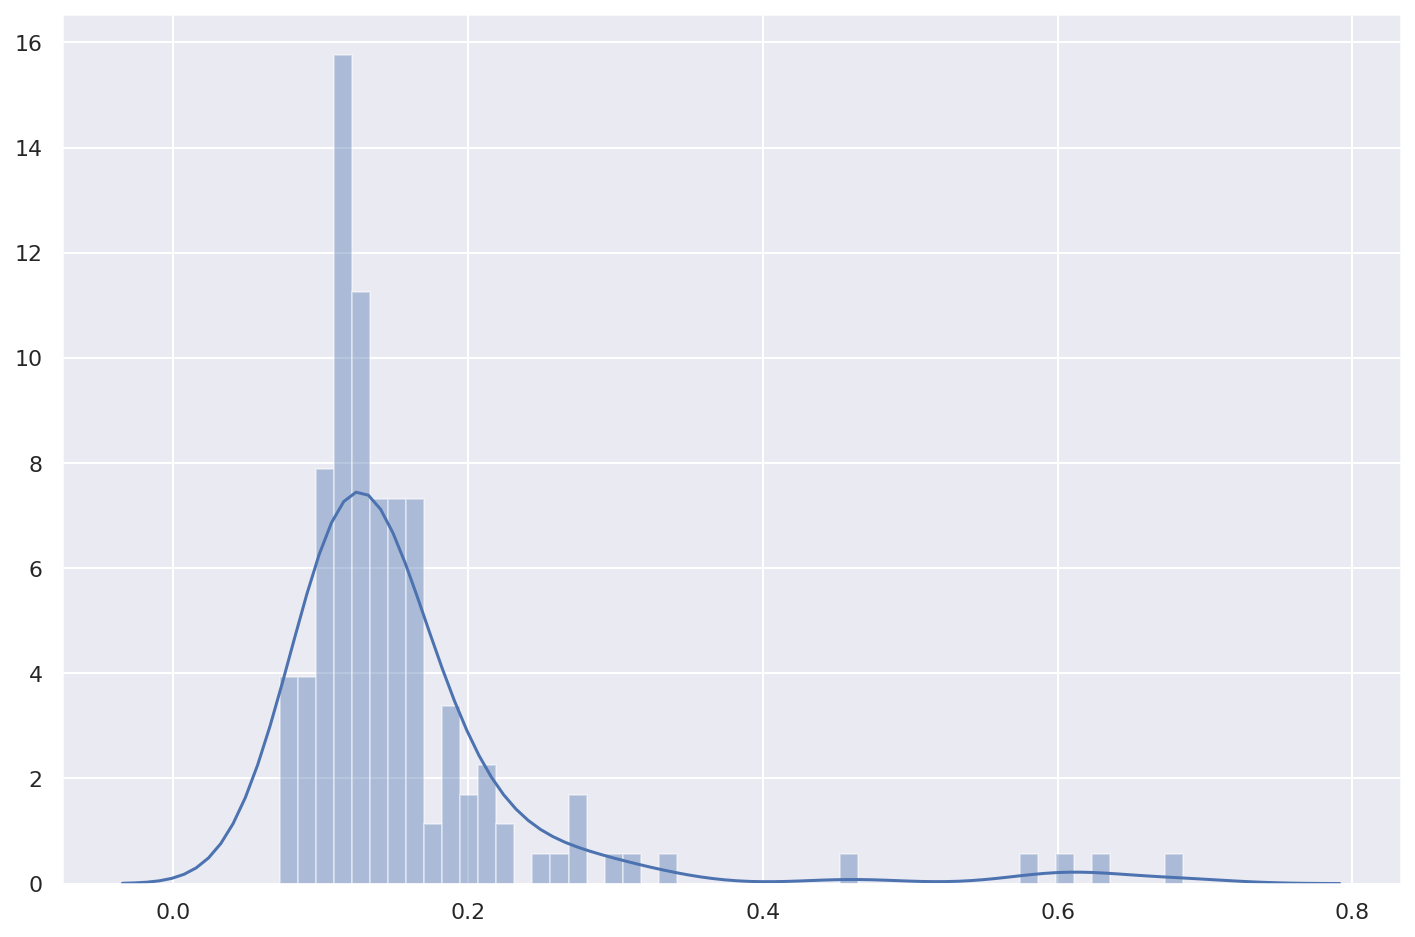

In [76]:
dataloader = DataLoader(test_dataset, batch_size=1)
normal_losses = one_epoch_test(0, network, optimizer, dataloader)
sns.distplot(normal_losses, bins=50, kde=True);

### 6.2.2. Check loss distribution for anomaly data

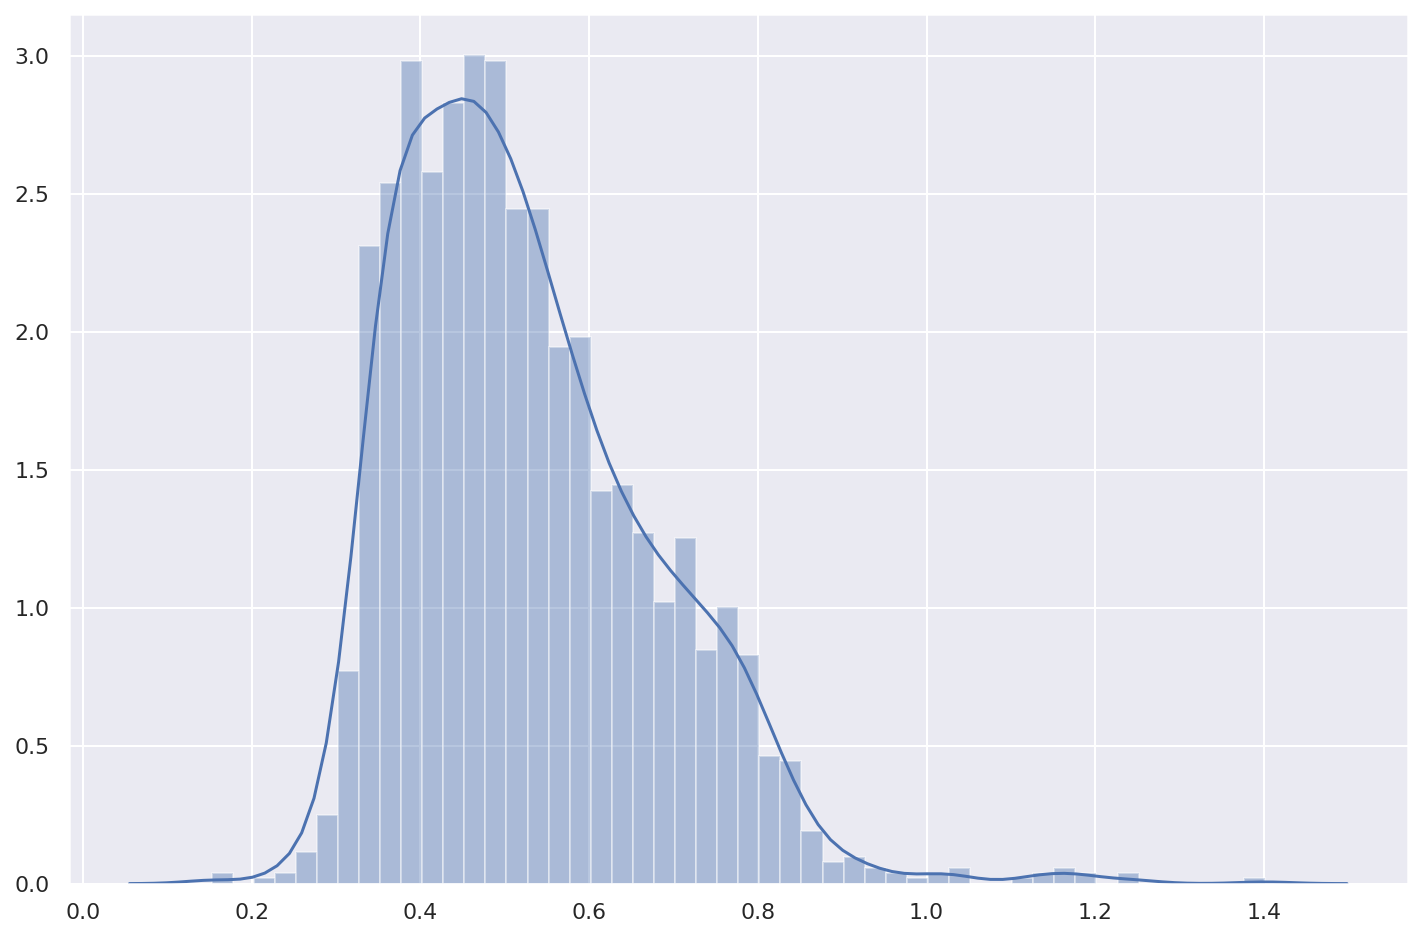

In [82]:
dataloader = DataLoader(test_anomaly_dataset, batch_size=1)
anomaly_losses = one_epoch_test(0, network, optimizer, dataloader)
sns.distplot(anomaly_losses, bins=50, kde=True);

### 6.2.3. Set Threshold

In [99]:
# We set
THRESHOLD = 0.29

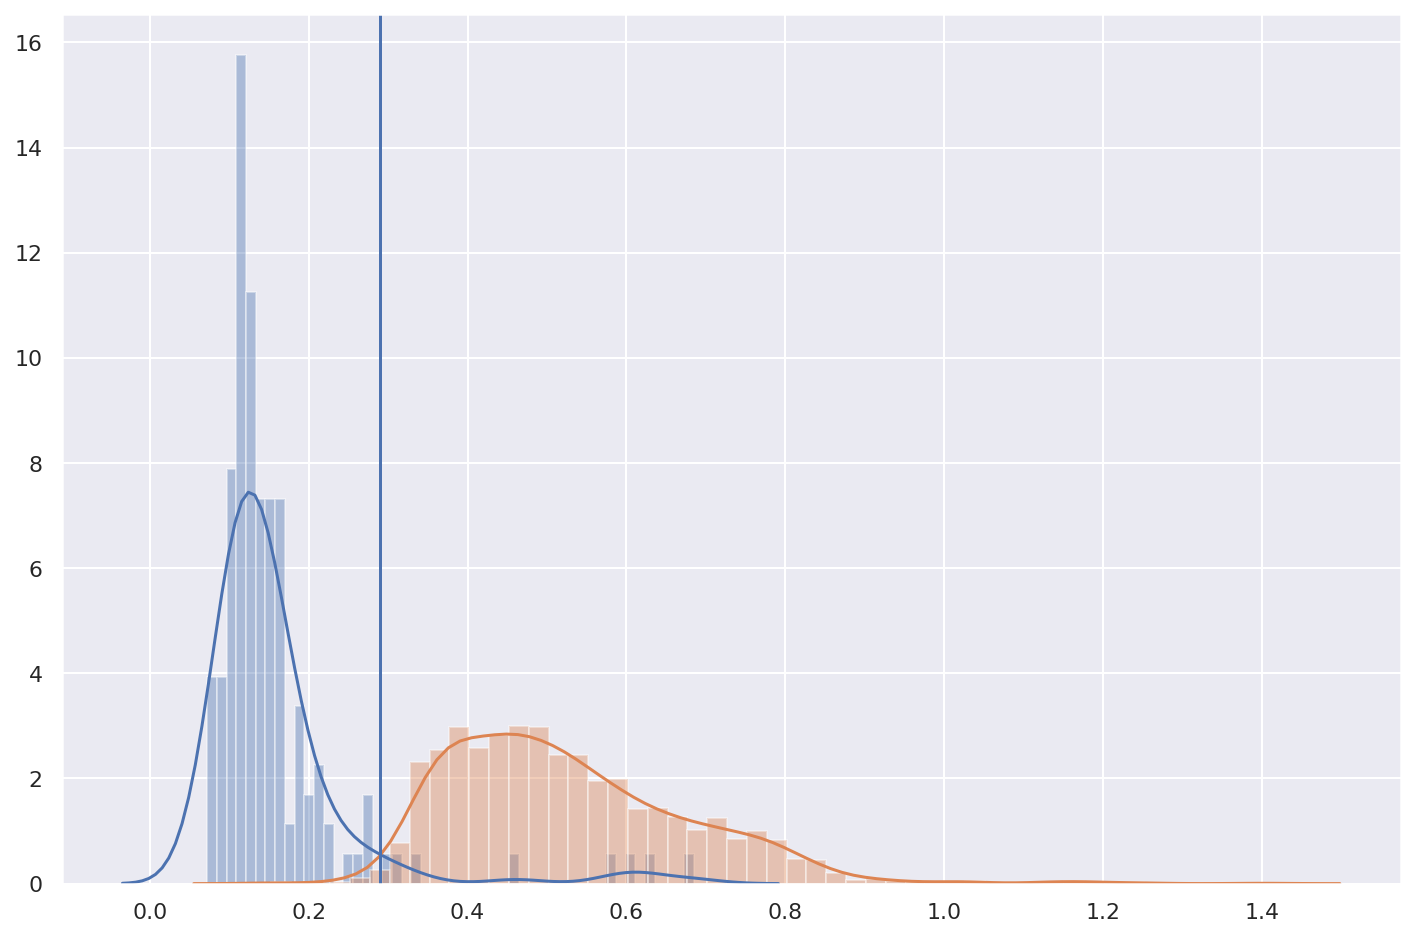

In [102]:
# Check the threshold in both distribution
sns.distplot(normal_losses, bins=50, kde=True)
ex = sns.distplot(anomaly_losses, bins=50, kde=True)
ex.axvline(THRESHOLD, 0)

In [103]:
correct = sum(l <= THRESHOLD for l in normal_losses)
print(f'Correct normal predictions: {correct}/{len(normal_losses)}')

Correct normal predictions: 137/145


In [104]:
correct = sum(l > THRESHOLD for l in anomaly_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_anomaly_dataset)}')

Correct anomaly predictions: 2066/2081


## 6.3. Check The Examples

In [158]:
# for predict a file
def predict(data):
    data = torch.FloatTensor(data)
    if torch.cuda.is_available():
        network.cuda()
        data = data.cuda()
        
    network.eval()
    with torch.no_grad():
        y_pred = network(data)
        
    return y_pred.cpu().numpy()

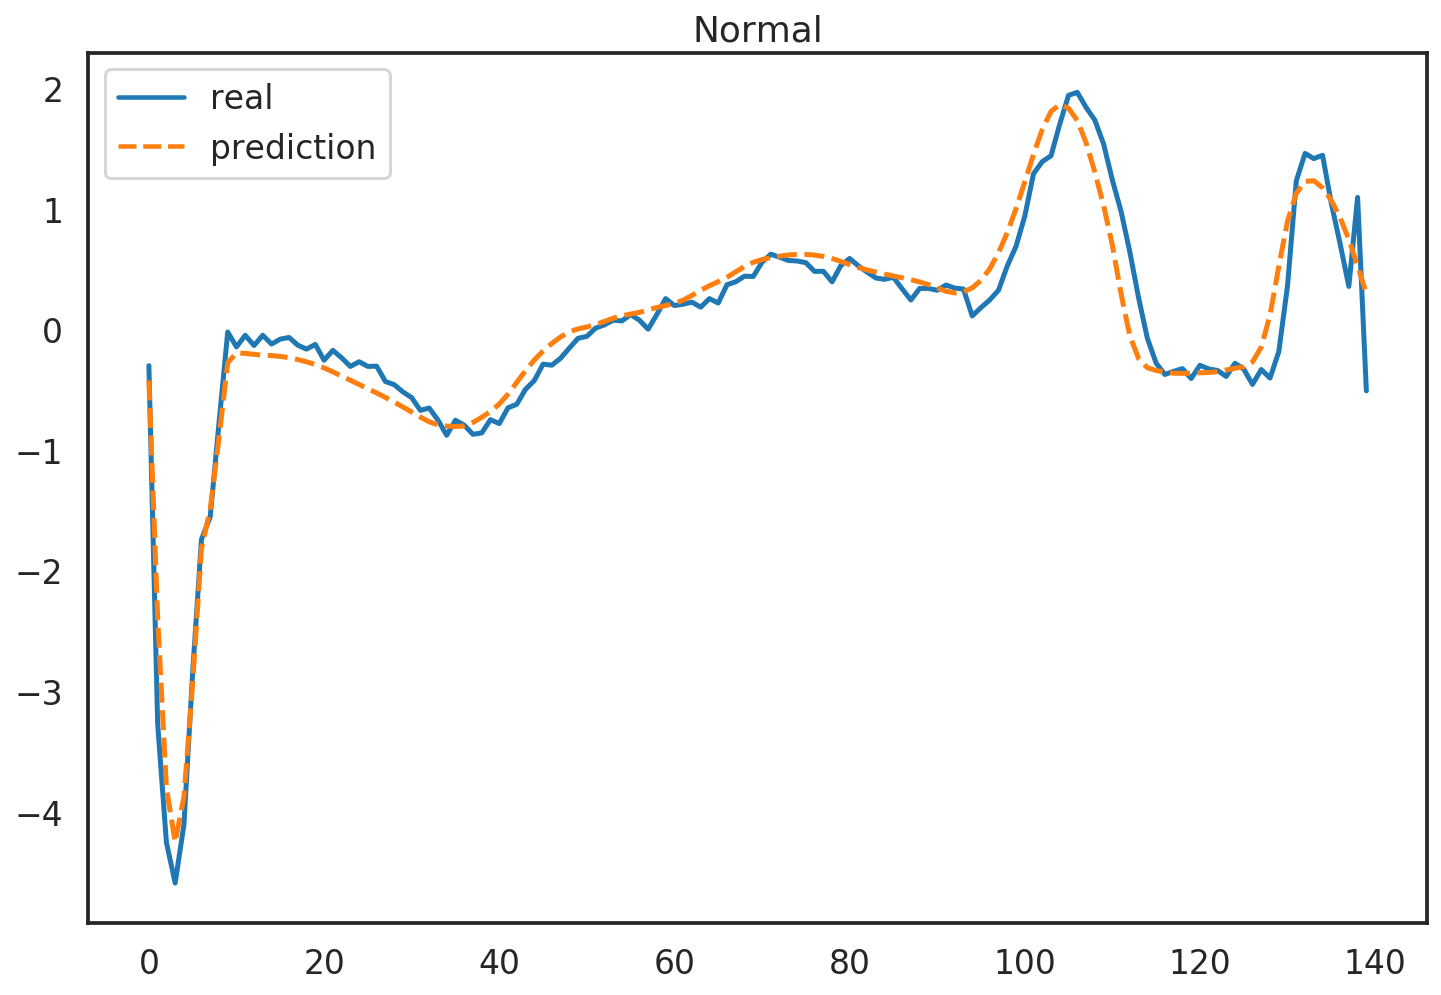

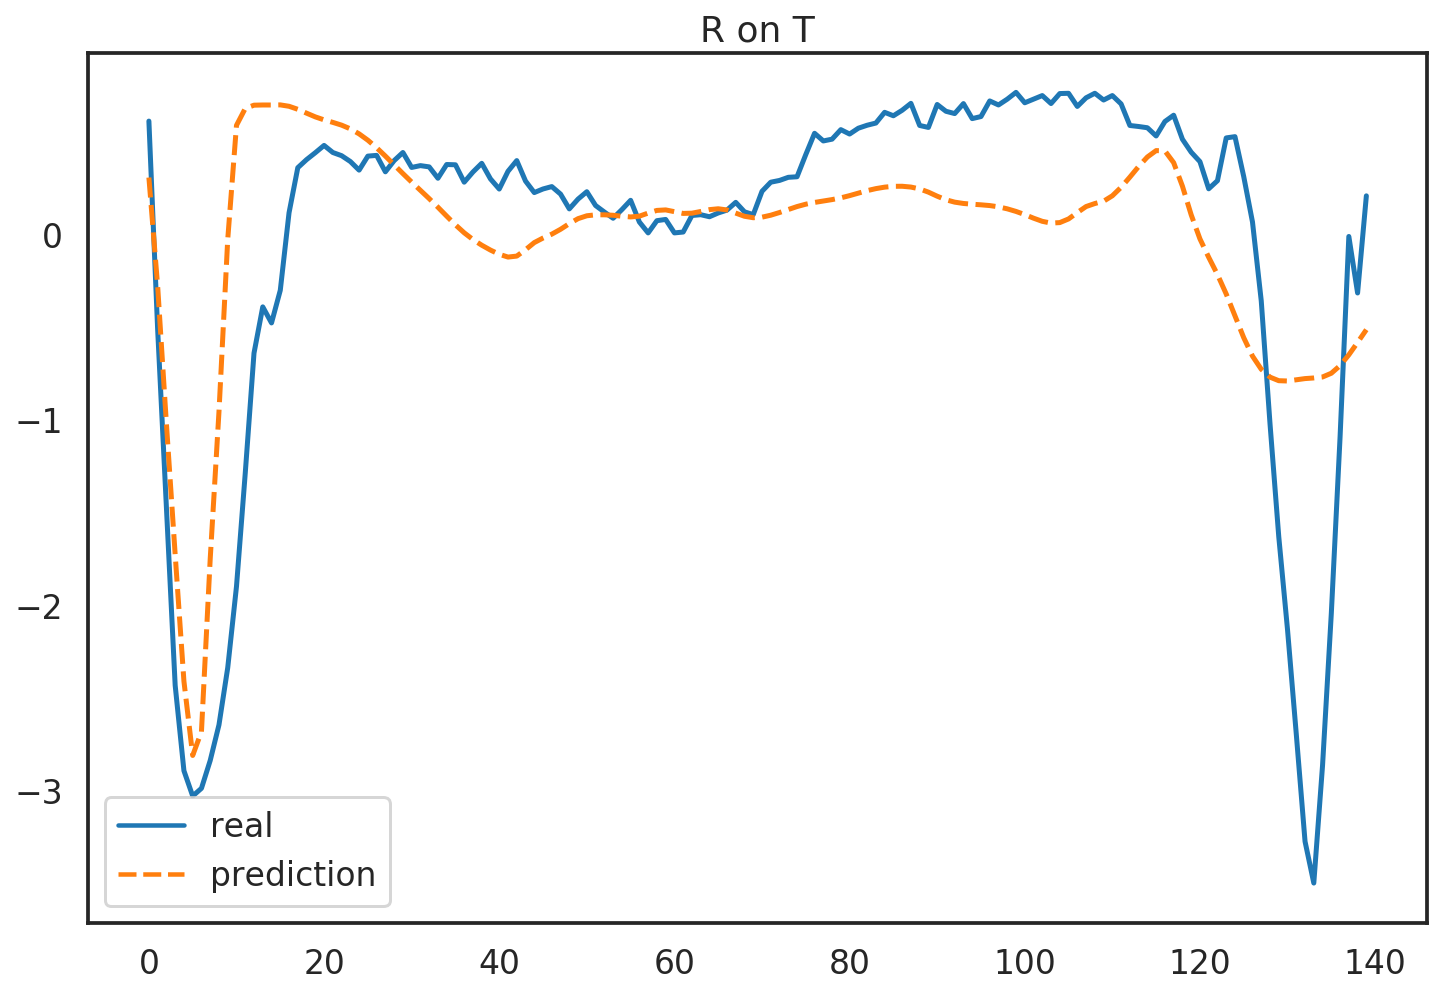

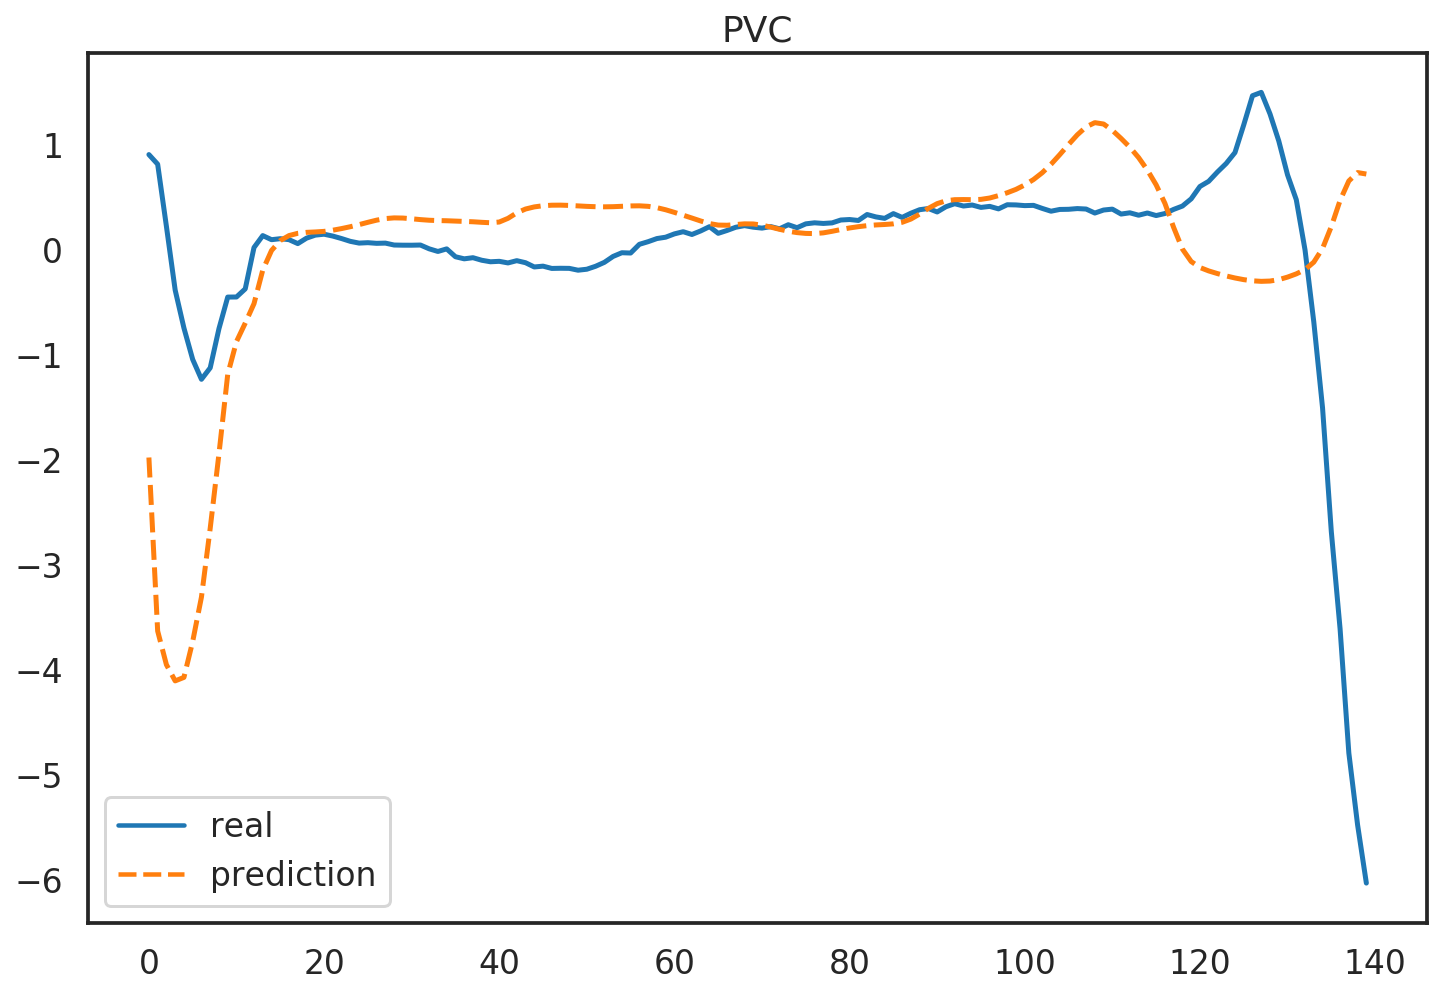

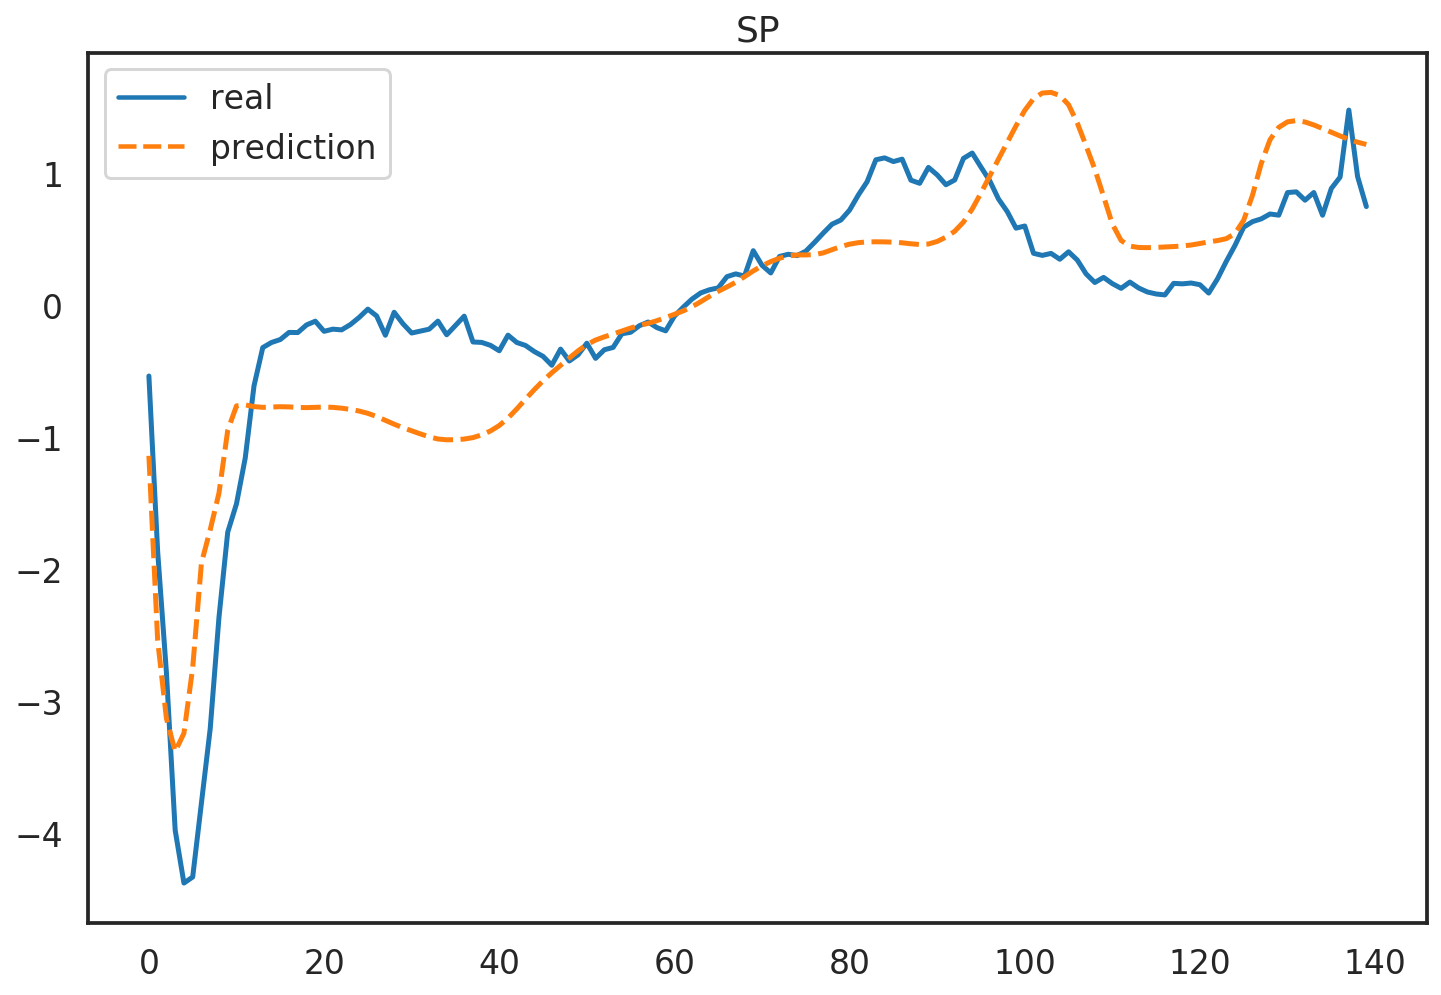

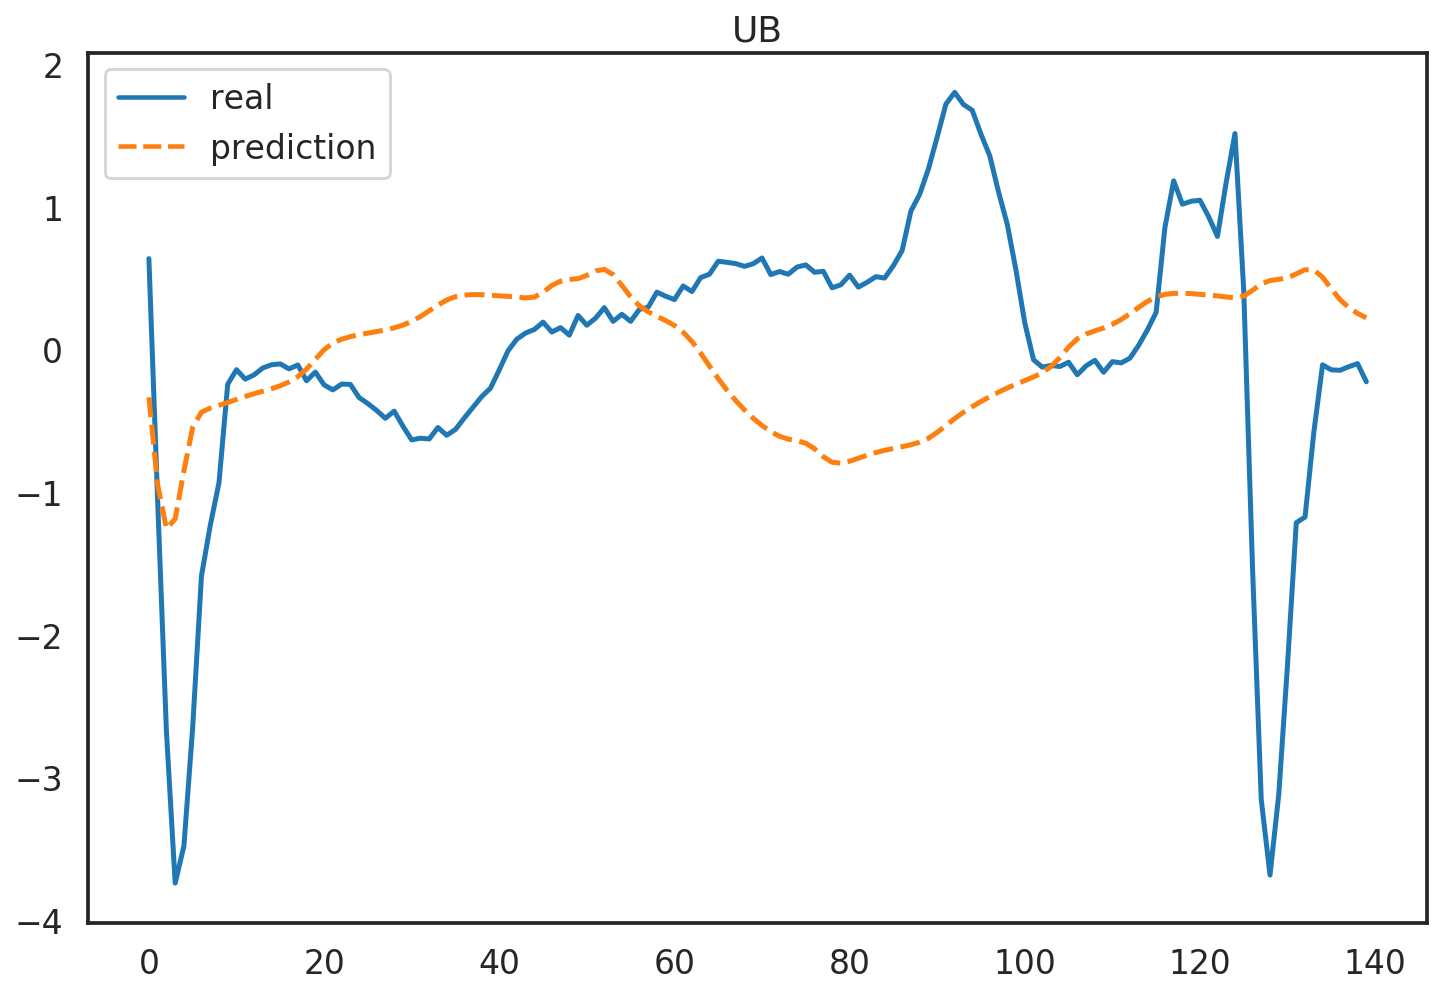

In [159]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# predict random
for i, c in enumerate(class_names):
    data = df[df['target']==i+1].iloc[:,:-1].sample().values
    pred = predict([data])
    _df = pd.DataFrame()
    _df['real'] = data.reshape(-1)
    _df['prediction'] = pred.reshape(-1)
    ax = sns.lineplot(data=_df, palette="tab10", linewidth=2.5)
    ax.set_title(c)
    plt.show()